In [1]:
# %matplotlib inline
%matplotlib widget
%load_ext autoreload
%autoreload 2
from IPython.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [2]:
import os
import sys
sys.path.insert(0, 'functions/')
from h5_tools import *
from fitting_tools import *
import numpy as np
import h5py as h5
import matplotlib as mpl
from matplotlib import pyplot as plt
import pandas as pd
# import pickle
# from matplotlib.colors import LogNorm

In [3]:
h5dir = '/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/'

# Select runs

In [4]:
!ls -l /cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/

total 60799731
-rw-rw-r--+ 1 mabi3848 hpc-users      23079 Jun 28 14:11 background_0003.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 6100272492 Jun 23 12:18 ferritin_conc_gly_50_5_0004_filtered.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 3054376047 Jun 20 00:02 ferritin_conc_gly_50_5_0004.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 5393549925 Jun 28 06:01 ferritin_conc_gly_50_5_0005_filtered.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 2697540517 Jun 20 09:32 ferritin_conc_gly_50_5_0005.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 2445210012 Jun 28 06:25 ferritin_conc_gly_50_5_0006_filtered.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 1223385279 Jun 19 23:57 ferritin_conc_gly_50_5_0006.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 5887411479 Jun 28 06:34 ferritin_conc_gly_50_6_0002_filtered.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 2945171489 Jun 20 14:57 ferritin_conc_gly_50_6_0002.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 5780836757 Jun 28 07:00 ferritin_conc_gly_50_6_0003_filtered.h5
-rw-rw-r--+ 1 mabi3848 hpc-users 2896089528 Jun 21 19:03 ferritin_conc_g

In [5]:
# fluxes 220K: 4 full beam, 5 45%, 6 22.5%
# runs = ['ferritin_conc_gly_50_5_0004', 'ferritin_conc_gly_50_6_0005', 'ferritin_conc_gly_50_6_0006']
# fluxes 220K: 4 full beam, 5 45%, 6 22.5%
runname = 'ferritin_conc_gly_50_5'
datasetnumbers = [4,5,6]

In [6]:
T, Tr = [], []

for i,datasetnumber in enumerate(datasetnumbers):
    filename = h5dir + f'{runname}_{datasetnumber:04d}_filtered.h5'

    if os.path.isfile(filename):
        print(filename, "\nFile exists: ", os.path.isfile(filename), "\n")
        info = elog_selected_entries_dict(filename)
        for key in info.keys():
            print("{0:20} {1}".format(key, info[key]))
        Tr.append(info['transmission (%)'])
        T.append(info['Temperature, K'])
    else:
        print(filename, "\nFile exists: False")

/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0004_filtered.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_5_0004
Temperature, K       220.0
transmission (%)     100
Absorbers 80um       0.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 220K, full beam
Exposure time (s)    0.0002
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0005_filtered.h5 
File exists:  True 

measurement folder   ferritin_conc_gly_50_5_0005
Temperature, K       220.0
transmission (%)     45
Absorbers 80um       1.0
Absorbers 100um      0.0
Short comment        nan
comment              xpcs, 4 reps per spot, 220K, 45% beam
Exposure time (s)    0.0004
number of frames     5000.0
/cfs/data/pg/sdaqs/esrf-ebs/id10/sc5275/20220614/processed/h5-files/ferritin_conc_gly_50_5_0006_filtered.h5 
File exists:  True 

measurement folder   ferriti

# Plot g2s

In [13]:
def exponential(x, beta, tau):
    return np.abs(beta) * np.exp( -2*x/(np.abs(tau)) )

def exponential_kww(x, beta, tau, kww):
    return np.abs(beta) * np.exp( -2*(x/(np.abs(tau)))**kww )

def linear(x, m):
    return m*x

In [14]:
filename = h5dir + f'{runname}_{datasetnumbers[0]:04d}.h5'
delay = load_data(filename, 'xpcs/g2s/delay')
qv = load_data(filename, 'xpcs/g2s/q')

rep = 0
g2s = np.empty(shape=(len(datasetnumbers),len(qv),len(delay)))

for i,datasetnumber in enumerate(datasetnumbers):
    filename = h5dir + f'{runname}_{datasetnumber:04d}.h5'
    g2s[i,:,:] = load_data(filename, 'xpcs/g2s/g2s')[rep,:,:]

print(np.shape(g2s))

(3, 12, 80)


In [15]:
beta_vs_q = np.load('../03-source/contrast_vs_q.npy')
beta_vs_q

array([0.14197197, 0.1418511 , 0.14160742, 0.14129188, 0.14093092,
       0.14038617, 0.13973972, 0.13903114, 0.13810638, 0.13725186,
       0.13657129, 0.13534967])

### With kww=1

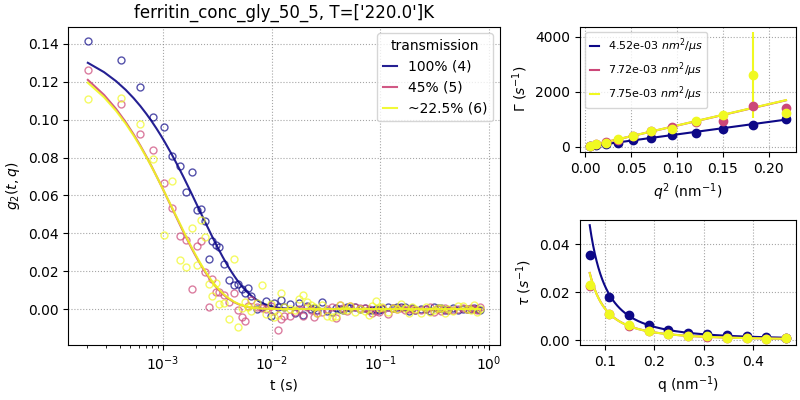

In [18]:
f = plt.figure(figsize=(8,4), constrained_layout=True)
gs = f.add_gridspec(2, 3)
a1 = f.add_subplot(gs[:2, :2])
a3 = f.add_subplot(gs[0, 2])
a4 = f.add_subplot(gs[1, 2])

col = plt.cm.plasma(np.linspace(0,1,len(datasetnumbers)))
# taus, dtaus = [], []
qv_sel = 5
tol = 1e-3
qv_min, qv_max = 1, len(qv)
for i in range(len(datasetnumbers)):
    taus, dtaus = [], []
    
    for q in range(qv_min, qv_max):
        base = np.average(g2s[i,q,-15:])
        # beta_p0 = 0.14
        popt,xc,curve,perr = fit(exponential, delay, g2s[i,q,:]-base, p0=[beta_vs_q[i],5e-2], bounds=[(beta_vs_q[i]-tol,0),(beta_vs_q[i]+tol,np.infty)])
        taus.append(popt[1])
        dtaus.append(perr[1])
        
        if q==qv_sel:
            a1.plot(delay, g2s[i,q,:]-base, c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7)
            a1.plot(xc, curve, c=col[i], ls='-', alpha=0.9, label=f'{Tr[i]}% ({datasetnumbers[i]})')

    taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    popt,xc,curve,perr = fit(linear, qv[qv_min:qv_max]**2, 1/taus, sigma=dtaus/(taus**2), p0=[5e3])
    a3.plot(xc, curve, c=col[i], label=f'{popt[0]*1e-6:.2e} ${{nm}}^{{2}}$/${{\mu s}}$')
    a4.plot(np.sqrt(xc), 1/curve, c=col[i], label=f'{popt[0]*1e-6:.2e} ${{nm}}^{{2}}$/${{\mu s}}$')
    a3.errorbar(qv[qv_min:qv_max]**2, 1/taus, dtaus/(taus**2), c=col[i], ls='', marker='o')
    a4.plot(qv[qv_min:qv_max], taus, c=col[i], ls='', marker='o')

a1.legend(title=r'transmission', fontsize=10, bbox_to_anchor=[1,1], handlelength=1)
a1.set_title(f"{runname}, T={T[:-2]}K")
a1.set_xscale('log')
a1.set_xlabel(r't (s)')
a1.set_ylabel(r'$g_2(t,q)$')
a3.set_xlabel(r'$q^2$ (nm$^{-1}$)')
a3.set_ylabel(r'$\Gamma$ ($s^{-1}$)')
a4.set_xlabel(r'q (nm$^{-1}$)')
a4.set_ylabel(r'$\tau$ ($s^{-1}$)')
a1.grid(ls=':', alpha=.7)
a3.grid(ls=':', alpha=.7)
a4.grid(ls=':', alpha=.7)
a3.legend(fontsize=8, handlelength=.8);

### Free kww

Text(0, 0.5, 'KWW')

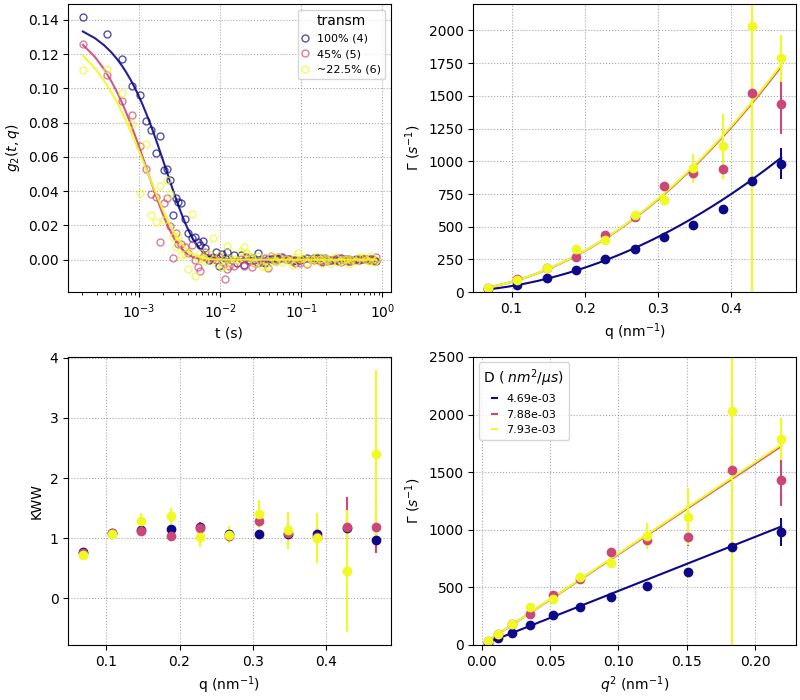

In [38]:
mpl.rcParams.update({"axes.grid" : True, "grid.color": "gray", "grid.linestyle":":", "grid.alpha": "0.7"})
f, ((a1,a2),(a3,a4)) = plt.subplots(2,2,figsize=(8,7), constrained_layout=True)

col = plt.cm.plasma(np.linspace(0,1,len(datasetnumbers)))

qv_sel = 5
tol = 1e-3
qv_min, qv_max = 1, len(qv)

for i in range(len(datasetnumbers)):
    taus, dtaus = [], []
    kww, dkww = [], []
    
    for q in range(qv_min, qv_max):
        base = np.average(g2s[i,q,-15:])
        popt,xc,curve,perr = fit(exponential_kww, delay, g2s[i,q,:]-base, p0=[beta_vs_q[q],5e-2,1.], 
                                 bounds=[(beta_vs_q[q]-tol,0,0),(beta_vs_q[q]+tol,np.infty,3)])
        taus.append(popt[1])
        dtaus.append(perr[1])
        kww.append(popt[2])
        dkww.append(perr[2])
        
        if q==qv_sel:
            a1.plot(delay, g2s[i,q,:]-base, c=col[i], ls='', marker='o', ms=5, mfc='none', alpha=0.7, label=f'{Tr[i]}% ({datasetnumbers[i]})')
            a1.plot(xc, curve, c=col[i], ls='-', alpha=0.9)#, label=f'{qv[q]:.2f}')
        
    taus, dtaus = np.asarray(taus), np.asarray(dtaus)
    kww, dkww = np.asarray(kww), np.asarray(dkww)

    popt,xc,curve,perr = fit(linear, qv[qv_min:qv_max]**2, 1/taus, sigma=dtaus/(taus**2), p0=[5e3])

    a2.plot(np.sqrt(xc), curve, c=col[i], label=f'{popt[0]*1e-6:.2e}')
    a2.errorbar(qv[qv_min:qv_max], 1/taus, dtaus/(taus**2),  c=col[i], ls='', marker='o')
    a4.plot(xc, curve, c=col[i], label=f'{popt[0]*1e-6:.2e}')
    a4.errorbar( qv[qv_min:qv_max]**2, 1/taus, dtaus/(taus**2),  c=col[i], ls='', marker='o')
    a3.errorbar(qv[qv_min:qv_max], kww, dkww, c=col[i], ls='', marker='o', label=f'{popt[0]*1e-6:.2e} ${{nm}}^{{2}}$/${{\mu s}}$')

# f.sup_title(f"{runname}, T={T[:-2]}K")
a1.legend(title=r'transm', fontsize=8, bbox_to_anchor=[1,1], handlelength=.5)
a4.legend(title=r'D ( ${{nm}}^{{2}}$/${{\mu s}}$)', fontsize=8, handlelength=.5)
a1.set_xscale('log')
a1.set_xlabel(r't (s)')
a1.set_ylabel(r'$g_2(t,q)$')
a2.set_xlabel(r'q (nm$^{-1}$)')
a2.set_ylabel(r'$\Gamma$ ($s^{-1}$)')
a2.set_ylim(0,2200)
a4.set_xlabel(r'$q^2$ (nm$^{-1}$)')
a4.set_ylabel(r'$\Gamma$ ($s^{-1}$)')
a4.set_ylim(0,2500)
a3.set_xlabel(r'q (nm$^{-1}$)')
a3.set_ylabel('KWW')